# Udforsk mekuni adl datasættet

In [1]:
## Importer biblioteker
import pandas as pd
from bs4 import BeautifulSoup as bs
import os
import re
from collections import Counter
import math
import matplotlib.pyplot as plt

### Læs CSV-filen

Indlæs datasættet fra en CSV-fil til en pandas DataFrame

In [2]:
df = pd.read_csv('adl_dataset_metadata.csv', encoding='utf')

In [3]:
df.head(2)

title      place  year  \
0  Bondens Søn ; Vadmelsfolk ; Vredens Børn. - 1919.  København  1918   
1                           Digte 1885-1908. - 1918.  København  1918   

           author  birth_year  death_year     xml_file_name  \
0  Aakjær, Jeppe.        1866        1930  aakjaer06val.xml   
1  Aakjær, Jeppe.        1866        1930  aakjaer01val.xml   

                                                 url  
0  https://tekster.kb.dk/text/adl-texts-aakjaer06...  
1  https://tekster.kb.dk/text/adl-texts-aakjaer01...

### Byg BeautifulSoup-elementer ud fra XML-dataene

In [4]:
# Udtræk en liste af XML fil navne fra DataFrame
xml_file_names = df['xml_file_name'].to_list()

# Byg en funktion, der kan indlæse en XML fil med BeautifulSoup biblioteket
def get_xml_file(file):

    try:
    
        file_path = r'./adl_xml_files_sample_set/' + file
    
        with open(file_path, 'r', encoding='utf-8') as file:
            xml_content = file.read()
    
        soup = bs(xml_content, 'lxml-xml')
    
        return soup

    except FileNotFoundError:
        pass

# Lav en liste af BeautifulSoup objects for hver XML fil
xml_soups = [get_xml_file(file) for file in xml_file_names ]

# Lav en ny DataFrame med XML filnavne og deres tilhørenden BeautifulSoup objects
df_soup = pd.DataFrame({'xml_file_name': xml_file_names,
                       'soup': xml_soups})

df_soup =  df_soup.dropna()

## Parse data fra xml

Dataen i kolonnen "soup" er BeautifulSoup-elementer, og vi kan parse tekstdata inde i de forskellige tags ved hjælp af BeautifulSoup-metoderne find_all og get_text.
Gennemgang af soup / xml viste, at parsing af body-tags og efterfølgende parsing af "p" og "l" tags inde i "body"-tags ville give os mest af den relevante tekstdata, fordi det udelader størstedelen af redaktørnoterne.

In [5]:
# Skriv en funktion der trækker text data ud fra specifikke tags (body, p, and l) i XML'en
def get_text_from_body_tags(s):
    body_tags = s.find_all(['body']) 
    p_l_tags = [i.find_all(['p', 'l']) for i in body_tags]
    p_l_tags = [i for y in p_l_tags for i in y]
    text = [i.get_text() for i in p_l_tags]
    text = ' '.join(text).replace('\n', ' ').replace('\t', ' ')
    text = re.sub(r'\s+', ' ', text)
    return text

# Applicer funktionen, udtræk tekst og gem den som værdier i en ny kolonne
df_soup['text'] = df_soup['soup'].apply(lambda s : get_text_from_body_tags(s))

In [6]:
df_soup.head(2)

xml_file_name                                               soup  \
3    bagger01val.xml  [[\n, [\n, <fileDesc xml:id="idm14062153911272...   
4  baggesen01val.xml  [[\n, [\n, <fileDesc xml:id="idm13989371598203...   

                                                text  
3  Og hvorfor vil I vel skilles ad, Kan Kjærlighe...  
4  F ortvivlelse! dig helliges min Sang, Og den, ...

## Kombiner data
Nu kan jeg kombinere data ved at merge de to dataframes; df og df_soup.

Kolonnen "soup" er nu mindre brugbar, så jeg vælger at droppe den fra dataframen.

In [7]:
# Forbind den oprindelige DataFrame med den ny DataFrame, der indeholder de tekster, som er udlæst af xlm filerne

mekuni_adl_dataset = pd.merge(df , df_soup, how='left', on='xml_file_name')

# Drop kollonen 'soup', fordi den skal ikke bruges mere
mekuni_adl_dataset.drop(columns=['soup'], inplace=True)
mekuni_adl_dataset = mekuni_adl_dataset.dropna()

mekuni_adl_dataset.head(2)

title      place  year           author  \
3                Udvalgte Skrifter.  København  1928    Bagger, Carl.   
4  Eventyr og Fortællinger. - 1889.  København  1889  Baggesen, Jens.   

   birth_year  death_year      xml_file_name  \
3        1807        1846    bagger01val.xml   
4        1764        1826  baggesen01val.xml   

                                                 url  \
3  https://tekster.kb.dk/text/adl-texts-bagger01v...   
4  https://tekster.kb.dk/text/adl-texts-baggesen0...   

                                                text  
3  Og hvorfor vil I vel skilles ad, Kan Kjærlighe...  
4  F ortvivlelse! dig helliges min Sang, Og den, ...

## Rens teksten

For at få mere ensartet tekstdata bruger jeg regex-metoder. Jeg bruger .findall() til at finde alt tekst mellem ordgrænser (\b = word bounderies), der ikke er whitespace (altså mellemrum). Jeg bruger .sub() og et regex mønster for at undgå tal, ord indeholdende tal, ord med en længde på 1 eller 2; og enhver sekvens af mere end ét whitespace. Til sidst konverterer jeg alle bogstaver til små bogstaver og returnerer den rensede tekst ud af funnktionen.

In [8]:
# En funktion til at rense teksten vha. regex-metoder
def clean(text): 

    # .findall() metoden returer en liste. Derfor bruger jeg .join() til at samle listen til en string
    text = ' '.join(re.findall(r'\b\S+\b', text))

    # Fjern tal og ord, der indeholder tal
    text = re.sub(r'\b\w*\d\w*\b', '', text)
    
    # Fjern korte ord (længde 1 eller 2)
    text = re.sub(r'\b\w{1,2}\b', '', text)
    
    # Fjern ekstra mellemrum (nogle gange opstår der ekstra mellemrum i rensning)
    text = re.sub(r'\s+', ' ', text) 

    # Konverter til små bogstaver
    text = text.lower()

    # returner teksten
    return text
    
# Apply the cleaning function to the text column
mekuni_adl_dataset['clean_text'] = mekuni_adl_dataset['text'].apply(lambda x: clean(x))

## Fjern stopord

Jeg vil anvende et collocation-værktøj senere, og i den vil jeg ikke inkludere stopord, så jeg vælger at lave nye tekststrenge uden stopord for at få bedre resultater ud af min collocation-analyse.

I mappen "stopwords" har jeg en txt-fil med stopord. Jeg læser filen ind i scriptet, laver den til en liste, og tilføjer plads til at tilføje yderligere ting til listen.

In [9]:
# Indlæs danske stopword fra en txt fil
sw_file = r'stopwords/adl_dataset_stopwords.txt'

with open(sw_file, 'r', encoding='utf-8') as f:
    stop_words = f.read().split()
    # Tilføj flere stopord eller grammatiske tegn efter behov
    stop_words.extend(['_', '/', "'"])

# Skriv en funktion, som fjerner stopord fra teksten
def remove_stopwords(clean_text):   
    # Fra tekststring til ordliste
    tokens = clean_text.split()
    tokens_wo_stopwords = [i for i in tokens if i.lower() not in stop_words]
    clean_text_wo_stopwords = ' '.join(tokens_wo_stopwords)
    return clean_text_wo_stopwords

# Applicer stopordsfunktionen og fjern stopord
mekuni_adl_dataset['clean_text_wo_stopwords'] = mekuni_adl_dataset['clean_text'].apply( lambda x : remove_stopwords(x))

In [10]:
mekuni_adl_dataset.head(2)

title      place  year           author  \
3                Udvalgte Skrifter.  København  1928    Bagger, Carl.   
4  Eventyr og Fortællinger. - 1889.  København  1889  Baggesen, Jens.   

   birth_year  death_year      xml_file_name  \
3        1807        1846    bagger01val.xml   
4        1764        1826  baggesen01val.xml   

                                                 url  \
3  https://tekster.kb.dk/text/adl-texts-bagger01v...   
4  https://tekster.kb.dk/text/adl-texts-baggesen0...   

                                                text  \
3  Og hvorfor vil I vel skilles ad, Kan Kjærlighe...   
4  F ortvivlelse! dig helliges min Sang, Og den, ...   

                                          clean_text  \
3   hvorfor vil vel skilles kan kjærlighed skifte...   
4   ortvivlelse dig helliges min sang den som hæn...   

                             clean_text_wo_stopwords  
3  skilles kjærlighed skiftes had harmfuldt sind ...  
4  ortvivlelse helliges sang hænger hang hænge ør...

## Kollokationer

Kollokation er en metode til at undersøge, hvilke ord der i et korpus optræder hyppigere end andre ord i nærheden af udvalgte nøgleord. 

Tilføj eller erstat nøgleorden med dine egne ord.

In [11]:
# Tilføj nøgleord til kollokations analysen
keywords = ['fader', 'moder', 'barn']

in_data_list = ' '.join(mekuni_adl_dataset['clean_text_wo_stopwords']).split()

# Forbered en dictionary til at holde styr på, hvor ofte andre ord optræder i nærheden af nøgleordene
keyword_proximity_counts = {keyword: Counter() for keyword in keywords}

# Juster "nærhed" 
window_size = 10

# Tæl ord i nærheden af hvert nøgleord
for i, token in enumerate(in_data_list):
    if token in keywords:
        # Definer vinduet / nærheden omkring nøgleordet
        start = max(0, i - window_size)
        end = min(len(in_data_list), i + window_size + 1)
        # Tæl ordene inden for vinduet, men ekskluder nøgleordet
        for j in range(start, end):
            if j != i:
                keyword_proximity_counts[token][in_data_list[j]] += 1

# Filtering af ord som optræder med en hyppighed færre gange eller lig med en udvalgt grænseværdi 
# Juster grænseværdien efter behov
threshold_value = 80
filtered_keyword_proximity_counts = {
    keyword: Counter({term: count for term, count in counts.items() if count >= 80})
    for keyword, counts in keyword_proximity_counts.items()}

## Visualiser kollokationerne
Hvis jeg udskriver indholdet af variablen "filtered_keyword_proximity_counts", kan vi se de forskellige nøgleord sammen med kollokationerne.

Det er kollokationerne, der findes efter, at vi har fjernet stopord og justeret vinduesstørrelsen til 10. Det kan være lidt forvirrende at se dataene i den udskrevne form, så jeg har valgt at bruge matplotlib til at visualisere kollokationerne med søjlediagrammer.

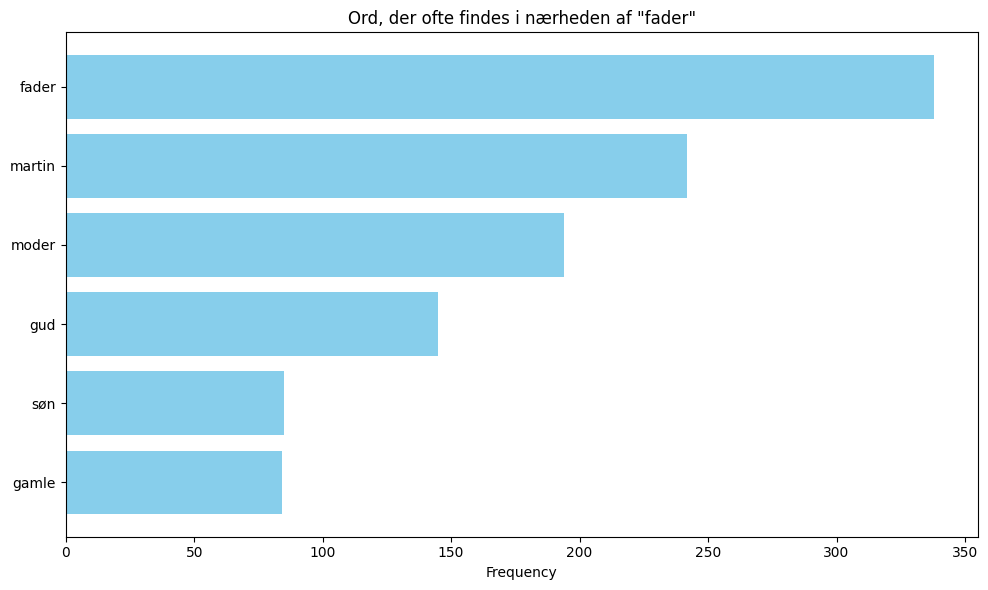

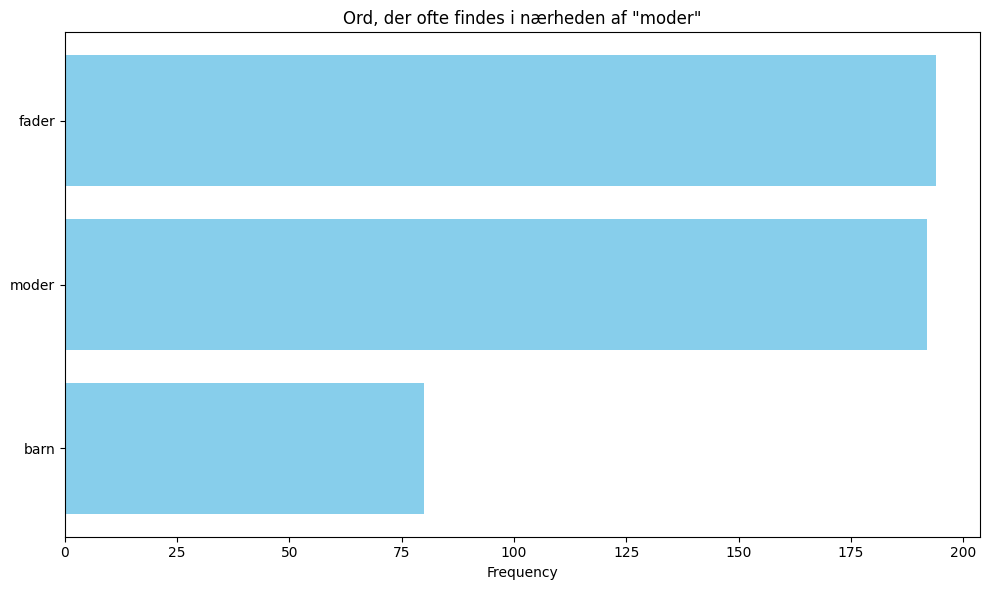

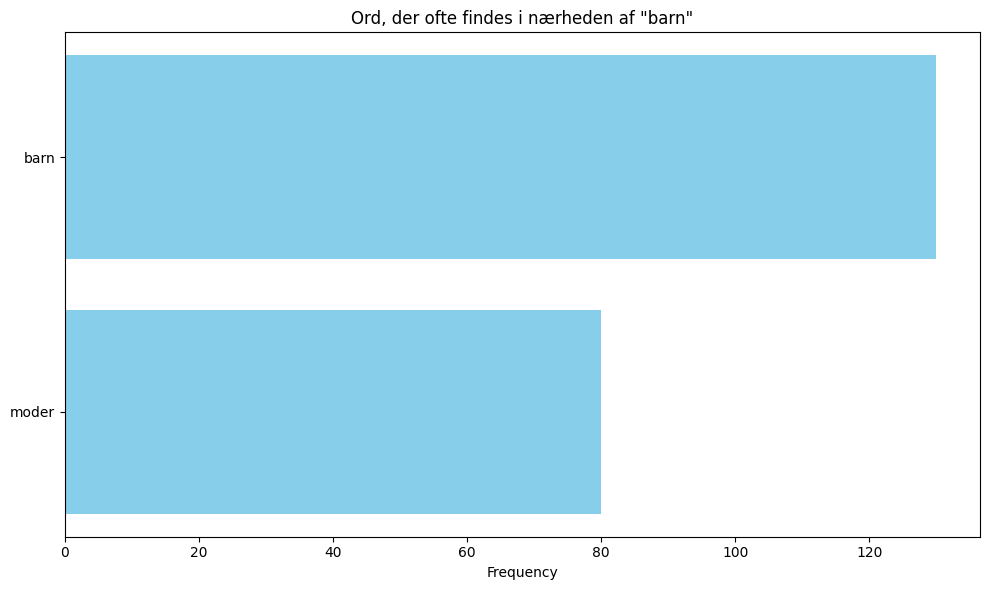

In [12]:
# Konverter hver gruppes sammentælling til en DataFrame og gem dem i en tom liste
dfs = []
for keyword, counter in filtered_keyword_proximity_counts.items():
    df = pd.DataFrame(counter.items(), columns=['Word', 'Frequency'])
    df['Keyword_Group'] = keyword
    dfs.append(df)

# Sammenkæd alle DataFrames fra listen
all_data = pd.concat(dfs, ignore_index=True)

# Lav individuelle søjlediagrammer for hver gruppe af nøgleord
for keyword in filtered_keyword_proximity_counts.keys():
    df_subset = all_data[all_data['Keyword_Group'] == keyword]
    plt.figure(figsize=(10,6))
    df_subset = df_subset.sort_values(by='Frequency', ascending=False).head(10)
    plt.barh(df_subset['Word'], df_subset['Frequency'], color='skyblue')
    plt.xlabel('Frequency')
    plt.title(f'Ord, der ofte findes i nærheden af "{keyword}"')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()